## New way of computing phi *

In [255]:
import mpmath as mp
from mpmath import *
import numpy as np
import pandas as pd
import time

mphi_tree = lambda phi, phigut, mphigut, xi : mphigut
lambda6_tree = lambda phi, phigut, lambda6gut : lambda6gut
A6_tree = lambda phi, phigut, A6gut, mphigut, xi : A6gut
g1 = lambda phi, phigut : g1gut/(mp.sqrt(1-pre*b1*g1gut**2*mp.log(phi/phigut)))
g2 = lambda phi, phigut : g2gut/(mp.sqrt(1-pre*b2*g2gut**2*mp.log(phi/phigut)))
g3 = lambda phi, phigut : g3gut/(mp.sqrt(1-pre*b3*g3gut**2*mp.log(phi/phigut)))

m1gut = lambda mphigut, xi : xi*mphigut
m2gut = lambda mphigut, xi : xi*mphigut
m3gut = lambda mphigut, xi : xi*mphigut

m1 = lambda phi, phigut, mphigut, xi : m1gut(mphigut, xi)*(g1(phi, phigut)/g1gut)**mp.mpf('2')
m2 = lambda phi, phigut, mphigut, xi : m2gut(mphigut, xi)*(g2(phi, phigut)/g2gut)**mp.mpf('2')
m3 = lambda phi, phigut, mphigut, xi : m3gut(mphigut, xi)*(g3(phi, phigut)/g3gut)**mp.mpf('2')

mphi_lle = lambda phi, phigut, mphigut, xi : mp.sqrt(mphigut**2+(m2gut(mphigut, xi)**2-m2(phi, phigut, mphigut, xi)**2)+mp.mpf('1')/11*(m1gut(mphigut, xi)**2-m1(phi, phigut,mphigut, xi)**2))
A6_lle = lambda phi, phigut, A6gut, mphigut, xi : A6gut-mp.mpf('6')*(m2gut(mphigut, xi)-m2(phi, phigut, mphigut, xi))-mp.mpf('6')/11*(m1gut(mphigut, xi)-m1(phi, phigut,mphigut, xi))
lambda6_lle = lambda phi, phigut, lambda6gut : lambda6gut*(g2gut/g2(phi, phigut))**mp.mpf('6')*(g1gut/g1(phi, phigut))**(mp.mpf('6')/11)
mphi_udd = lambda phi, phigut, mphigut, xi : mp.sqrt(mphigut**2-mp.mpf('8')/9*(m3gut(mphigut, xi)**2-m3(phi, phigut, mphigut, xi)**2)+mp.mpf('4')/99*(m1gut(mphigut, xi)**2-m1(phi, phigut, mphigut, xi)**2))
A6_udd = lambda phi, phigut, A6gut, mphigut, xi : A6gut+mp.mpf('16')/3*(m3gut(mphigut, xi)-m3(phi, phigut, mphigut, xi))-mp.mpf('8')/33*(m1gut(mphigut, xi)-m1(phi, phigut, mphigut, xi))
lambda6_udd = lambda phi, phigut, lambda6gut: lambda6gut*(g3gut/g3(phi, phigut))**(mp.mpf('-16')/3)*(g1gut/g1(phi, phigut))**(mp.mpf('8')/33)

def V_MSSM(phi, infl_type, mphigut, A6gut, lambda6gut, xi):
    if infl_type == 0 or infl_type == 'tree':
        mphi_func, A6_func, lambda6_func = mphi_tree, A6_tree, lambda6_tree
    elif infl_type == 1 or infl_type == 'lle':
        mphi_func, A6_func, lambda6_func = mphi_lle, A6_lle, lambda6_lle
    elif infl_type == 2 or infl_type == 'udd':
        mphi_func, A6_func, lambda6_func = mphi_udd, A6_udd, lambda6_udd
    else:
        return 'Error: unknown type of inflation'
    lambda6 = lambda6_func(phi, phigut, lambda6gut)
    mphi = mphi_func(phi, phigut,mphigut, xi)
    A6 = A6_func(phi, phigut, A6gut, mphigut, xi)
    V = mp.mpf('0.5')*mphi**mp.mpf('2')*phi**mp.mpf('2')-lambda6*A6/(mp.mpf('6')*Mp**mp.mpf('3'))*phi**mp.mpf('6')+lambda6**mp.mpf('2')*phi**mp.mpf('10')/Mp**mp.mpf('6')
    return V


def DV(V,phi):
    return mp.diff(V, phi, addprec=addprec_deriv)
def D2V(V, phi):
    return mp.diff(V, phi, 2, addprec=addprec_deriv)
def eps1_(V, phi):
#     with extradps(10):
    return Mp**2/2*(DV(V,phi)/V(phi))**2

def eps2_(V, phi):
#     with extradps(10):
    return 2*Mp**2*((DV(V,phi)/V(phi))**2-D2V(V,phi)/V(phi))

def N_low(V, phimin, phimax):
#     with extradps(10):
    integ = mp.quad(lambda phi : V(phi)/DV(V, phi), [phimin, phimax], verbose=False, method='tanh-sinh')
    print(nstr(-integ/Mp**2, 20), end=', ')
    return -integ/Mp**2

def find_phi_st(V, phi, phi_end, Pstar, lnRrad):
    kstar, lnMpcToKappa, HubbleSquareRootOf3OmegaRad, RelatDofRatio = mp.mpf('0.05'), mp.mpf('130.282'), mp.mpf('7.5437e-63'), mp.mpf('1')
    N0 = log(kstar) - lnMpcToKappa - 0.5*log(HubbleSquareRootOf3OmegaRad) -mp.mpf('0.25')*log(RelatDofRatio)
    Delta_N_star = N_low(V, phi, phi_end)
    return -Delta_N_star + lnRrad - N0 - 0.25*mp.log(9/eps1_(V, phi)/(3-eps1_(V, phi_end))*V(phi_end)/V(phi))+0.25*mp.log(8*mp.pi**2*Pstar)

def endinf(V, start):
    return mp.findroot(lambda phi: eps1_(V, phi)-1, 0.95*start)

def phi_star(V, Pstar, lnRrad, phi_single):
    print('decimal prec of computations :', mp.dps)
    phi_start = mp.findroot(lambda phi : D2V(V, phi), phi_single)
    phi_end = endinf(V, phi_start*0.98)
    kstar, lnMpcToKappa, HubbleSquareRootOf3OmegaRad, RelatDofRatio = mp.mpf('0.05'), mp.mpf('130.282'), mp.mpf('7.5437e-63'), mp.mpf('1')
    N0 = log(kstar) - lnMpcToKappa - 0.5*log(HubbleSquareRootOf3OmegaRad) -mp.mpf('0.25')*log(RelatDofRatio)

    mp.plot([lambda phi : N_low(V, phi, phi_end), lambda phi : lnRrad - N0 - 0.25*mp.log(9/eps1_(V, phi)/(3-eps1_(V, phi_end))*V(phi_end)/V(phi))+0.25*mp.log(8*mp.pi**2*Pstar)], xlim = (phi_start*(1-shift_plot),phi_start*(1+shift_plot)), points=20)
#     mp.plot([lambda phi : N_low(V, phi, phi_end),lambda phi : N(V, phi, phi_end), lambda phi : lnRrad - N0 - 0.25*mp.log(9/eps1_(V, phi)/(3-eps1_(V, phi_end))*V(phi_end)/V(phi))+0.25*mp.log(8*mp.pi**2*Pstar)], xlim = (8028264255854228,8028264255874228), points=20)
    mp.plot([lambda phi : eps2_(V, phi)], xlim = (phi_start*(1-shift_plot),phi_start*(1+shift_plot)), points=100)
    phi_star = mp.findroot(lambda phi : find_phi_st(V, phi, phi_end, Pstar, lnRrad), x0 = (phi_start-10,phi_start+10), verbose = True, tol=1e-21, method='ridder')
    print(phi_star)
    return phi_star

def ns_(V, phi):
    return mp.fsub(mp.fsub(1,2*eps1_(V, phi)),eps2_(V, phi))

def P_star(V, phi_sta):
    Vstar = V(phi_sta)
    eps1star = eps1_(V, phi_sta)
    return Vstar/(Mp**4*24*mp.pi**2*eps1star)




decimal prec of computations : 17
13.68643973952952031, 14.978855203464451484, 16.513887675199593996, 18.356252930117955058, 20.589702570859705233, 23.319469255028713428, 26.668781133463968669, 30.759615603066023715, 35.662699008592218142, 41.311404712756652491, 47.423704893710764918, 53.536005079402514739, 59.18471079569975829, 64.087794216397062308, 68.178628700621693337, 71.527940591481296129, 74.257707285534541808, 76.491156934039594373, 78.333522194533458771, 79.86855465406833976, 

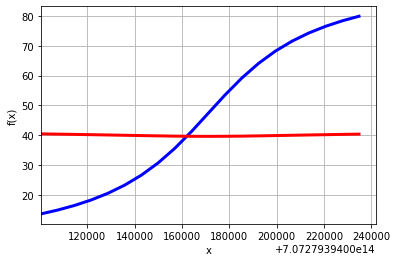

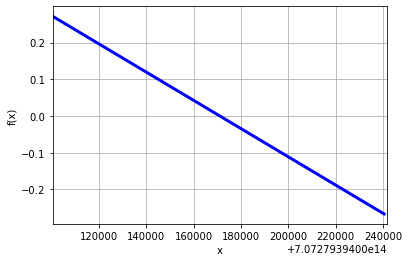

47.414942865478810736, 47.414942865478810736, 47.432466921936558631, x:     707279394162296.20212271
error: 20.0
39.821901160645462946, x:     707279394162142.01758772
error: 8873.9677991671487689018
39.695327157686063307, x:     707279394162135.82442913
error: 154.18453499209135770798
39.690248802895390417, x:     707279394162135.81787079
error: 6.1931585827842354774475
39.690243425332515283, x:     707279394162135.81787053
error: 0.0065583381801843643188477
39.690243425111821731, x:     707279394162135.81787053
error: 2.6915222406387329101563e-7
39.690243425111821731, 707279394162135.82
ns = 0.965300000404
As = 2.09890077481e-9


In [256]:
dps_def = 17
mp.dps = dps_def

extradps_def = 10
addprec_deriv = 25

shift_plot = 1e-10
# shift_plot = 1e-8

# def every global with +10 prec
with extradps(extradps_def):
    lnMpinGev = mp.mpf('42.334')
    Mp = mp.exp(lnMpinGev)
    g1gut, g2gut, g3gut = mp.sqrt(mp.pi/mp.mpf('6')), mp.sqrt(mp.pi/mp.mpf('6')), mp.sqrt(mp.pi/mp.mpf('6'))
    pre = mp.mpf('1')/(mp.mpf('8')*mp.pi**2)
    b1, b2, b3 = mp.mpf('33')/mp.mpf('5'), mp.mpf('1'), mp.mpf('-3')

#     mphi = mp.mpf('414233.261967746641684789070606')
#     A6 = mp.mpf('2728893.70084853010219399225824')
#     lambda6 = mp.mpf('0.000431489453210000260210321369278')
    mphi = mp.mpf('3739.15081376237001262552747081')
    A6 = mp.mpf('26964.054475578353454618649417')
    lambda6 = mp.mpf('0.058573313975942598534088758032')

# phi0 = mp.mpf('8028264269043385.60868491293049')
phi0 = mp.mpf('7.1e14')
infl_type='udd'
phigut = mp.mpf('3e16')
xi=mp.mpf('1')


V = lambda phi : V_MSSM(phi, infl_type, mphi, A6, lambda6, xi)
phi_sta = phi_star(V, mp.mpf('2.0989031673191437e-9'), mp.mpf('0'), phi0)
ns_star = ns_(V, phi_sta)
P_sta = P_star(V, phi_sta)
print('ns =',nstr(ns_star, 12))
print('As =',nstr(P_sta, 12))

## Old way

In [100]:
import mpmath as mp
from mpmath import *
import numpy as np
import pandas as pd
import time

mp.dps = 500
mp.prec = 166

lnMpinGev = mp.mpf('42.334')
Mp = mp.exp(lnMpinGev)

mphi_tree = lambda phi, phigut, mphigut, xi : mphigut
lambda6_tree = lambda phi, phigut, lambda6gut : lambda6gut
A6_tree = lambda phi, phigut, A6gut, mphigut, xi : A6gut

g1gut, g2gut, g3gut = mp.sqrt(mp.pi/mp.mpf('6')), mp.sqrt(mp.pi/mp.mpf('6')), mp.sqrt(mp.pi/mp.mpf('6'))
pre = mp.mpf('1')/(mp.mpf('8')*mp.pi**2)
b1, b2, b3 = mp.mpf('33')/mp.mpf('5'), mp.mpf('1'), mp.mpf('-3')
g1 = lambda phi, phigut : g1gut/(mp.sqrt(1-pre*b1*g1gut**2*mp.log(phi/phigut)))
g2 = lambda phi, phigut : g2gut/(mp.sqrt(1-pre*b2*g2gut**2*mp.log(phi/phigut)))
g3 = lambda phi, phigut : g3gut/(mp.sqrt(1-pre*b3*g3gut**2*mp.log(phi/phigut)))

# xi = mp.mpf('1') # éventuellement le passer en argument
m1gut = lambda mphigut, xi : xi*mphigut
m2gut = lambda mphigut, xi : xi*mphigut
m3gut = lambda mphigut, xi : xi*mphigut

m1 = lambda phi, phigut, mphigut, xi : m1gut(mphigut, xi)*(g1(phi, phigut)/g1gut)**mp.mpf('2')
m2 = lambda phi, phigut, mphigut, xi : m2gut(mphigut, xi)*(g2(phi, phigut)/g2gut)**mp.mpf('2')
m3 = lambda phi, phigut, mphigut, xi : m3gut(mphigut, xi)*(g3(phi, phigut)/g3gut)**mp.mpf('2')

mphi_lle = lambda phi, phigut, mphigut, xi : mp.sqrt(mphigut**2+(m2gut(mphigut, xi)**2-m2(phi, phigut, mphigut, xi)**2)+mp.mpf('1')/11*(m1gut(mphigut, xi)**2-m1(phi, phigut,mphigut, xi)**2))
A6_lle = lambda phi, phigut, A6gut, mphigut, xi : A6gut-mp.mpf('6')*(m2gut(mphigut, xi)-m2(phi, phigut, mphigut, xi))-mp.mpf('6')/11*(m1gut(mphigut, xi)-m1(phi, phigut,mphigut, xi))
lambda6_lle = lambda phi, phigut, lambda6gut : lambda6gut*(g2gut/g2(phi, phigut))**mp.mpf('6')*(g1gut/g1(phi, phigut))**(mp.mpf('6')/11)
mphi_udd = lambda phi, phigut, mphigut, xi : mp.sqrt(mphigut**2-mp.mpf('8')/9*(m3gut(mphigut, xi)**2-m3(phi, phigut, mphigut, xi)**2)+mp.mpf('4')/99*(m1gut(mphigut, xi)**2-m1(phi, phigut, mphigut, xi)**2))
A6_udd = lambda phi, phigut, A6gut, mphigut, xi : A6gut+mp.mpf('16')/3*(m3gut(mphigut, xi)-m3(phi, phigut, mphigut, xi))-mp.mpf('8')/33*(m1gut(mphigut, xi)-m1(phi, phigut, mphigut, xi))
lambda6_udd = lambda phi, phigut, lambda6gut: lambda6gut*(g3gut/g3(phi, phigut))**(mp.mpf('-16')/3)*(g1gut/g1(phi, phigut))**(mp.mpf('8')/33)

def V_MSSM(phi, infl_type, mphigut, A6gut, lambda6gut, xi):
    phigut = mp.mpf('3e16')
    if infl_type == 0 or infl_type == 'tree':
        mphi_func, A6_func, lambda6_func = mphi_tree, A6_tree, lambda6_tree
    elif infl_type == 1 or infl_type == 'lle':
        mphi_func, A6_func, lambda6_func = mphi_lle, A6_lle, lambda6_lle
    elif infl_type == 2 or infl_type == 'udd':
        mphi_func, A6_func, lambda6_func = mphi_udd, A6_udd, lambda6_udd
    else:
        return 'Error: unknown type of inflation'
    lambda6 = lambda6_func(phi, phigut, lambda6gut)
    mphi = mphi_func(phi, phigut,mphigut, xi)
    A6 = A6_func(phi, phigut, A6gut, mphigut, xi)
    V = mp.mpf('0.5')*mphi**mp.mpf('2')*phi**mp.mpf('2')-lambda6*A6/(mp.mpf('6')*Mp**mp.mpf('3'))*phi**mp.mpf('6')+lambda6**mp.mpf('2')*phi**mp.mpf('10')/Mp**mp.mpf('6')
    return V


# def DV(V, phi):
#      return (V(phi+1)-V(phi-1))/mp.mpf('2')

# def D2V(V, phi):
#     return (V(phi+1)+V(phi-1)-2*V(phi))/mp.mpf('1')
def DV(V,phi):
#     return (V(phi+1)-V(phi-1))/mp.mpf('2')
    return mp.diff(V, phi)
def D2V(V, phi):
#     return (V(phi+1)+V(phi-1)-2*V(phi))/mp.mpf('1')
    return mp.diff(V, phi, 2)
def eps1_(V, phi):
    return mp.fdiv(mp.power((mp.fmul((mp.mpf(1)*Mp),mp.fdiv(DV(V, phi),V(phi)))),2),2)

def eps2_(V, phi):
    return mp.fmul(mp.fmul(2,mp.power(Mp,2)),mp.fsub(mp.power(mp.fdiv(DV(V, phi),V(phi)),2),mp.fdiv(D2V(V, phi),V(phi))))

def N(V, phimin, phimax):
    mp.dps=50
    integ = mp.quad(lambda phi : V(phi)/DV(V, phi), [phimin, phimax], verbose=False)
    print(nstr(-integ/Mp**2, 20), end=', ')
    mp.dps = 25
    return -integ/Mp**2


def find_phi_st(V, phi, phi_end, Pstar, lnRrad):
    kstar, lnMpcToKappa, HubbleSquareRootOf3OmegaRad, RelatDofRatio = mp.mpf('0.05'), mp.mpf('130.282'), mp.mpf('7.5437e-63'), mp.mpf('1')
    N0 = log(kstar) - lnMpcToKappa - 0.5*log(HubbleSquareRootOf3OmegaRad) -mp.mpf('0.25')*log(RelatDofRatio)
    Delta_N_star = N(V, phi, phi_end)
    return -Delta_N_star + lnRrad - N0 - 0.25*mp.log(9/eps1_(V, phi)/(3-eps1_(V, phi_end))*V(phi_end)/V(phi))+0.25*mp.log(8*mp.pi**2*Pstar)

def endinf(V, start):
    return mp.findroot(lambda phi: eps1_(V, phi)-1, 0.95*start, tol = 1e-30)

def phi_star(V, Pstar, lnRrad, phi_single):
    # extensions dispos si pas de guess, ou si on explore les potentiels non monotones
    phi_0 = mp.findroot(lambda phi : D2V(V, phi), phi_single, tol=5e-18)
    try:
        phi_0
    except:
        print('échec trouver un phi_0')
        return nan
    phi_start = phi_0
    phi_end = endinf(V, phi_start*0.98)
    Ntot = N(V, phi_end, phi_start-1)

    if -Ntot > 22.4:
#         try:
        phi_star = mp.findroot(lambda phi : find_phi_st(V, phi, phi_end, Pstar, lnRrad), x0 = (phi_start-10,phi_start+10), maxsteps = 30, verbose = False, method='ridder', tol = 1e-25)
        return phi_star
#         except:
#             print('échec trouver un phi_star (malgré assez efolds...)')
#             return mp.mpf(nan)
    else:
        print('pas assez efolds')
        return float(nan)

def ns_(V, phi):
    return mp.fsub(mp.fsub(1,2*eps1_(V, phi)),eps2_(V, phi))

def P_star(V, phi_sta):
    Vstar = V(phi_sta)
    eps1star = eps1_(V, phi_sta)
    return Vstar/(Mp**4*24*mp.pi**2*eps1star)




In [7]:
mphi = mp.mpf('414233.261967746641684789070606')
A6 = mp.mpf('2728893.70084853010219399225824')
lambda6 = mp.mpf('0.000431489453210000260210321369278')
phi0 = mp.mpf('8028264269043385.60868491293049')
infl_type='udd'
xi=1

V = lambda phi : V_MSSM(phi, infl_type, mphi, A6, lambda6, xi)
phi_sta = phi_star(V, mp.mpf('2.0989031673191437e-9'), mp.mpf('0'), phi0)
ns_star = ns_(V, phi_sta)
P_sta = P_star(V, phi_sta)
print('ns =',nstr(ns_star, 12))
print('As =',nstr(P_sta, 12))

Integrating from 7.95471e+15 to 8.02826e+15 (degree 1 of 8)
Integrating from 7.95471e+15 to 8.02826e+15 (degree 2 of 8)
Estimated error: 3.01568e+38  epsilon: 3.34096e-52  result:  3.82962e+38
Integrating from 7.95471e+15 to 8.02826e+15 (degree 3 of 8)
Estimated error: 1.0  epsilon: 3.34096e-52  result:  3.13361e+38
Integrating from 7.95471e+15 to 8.02826e+15 (degree 4 of 8)
Estimated error: 1.0  epsilon: 3.34096e-52  result:  3.11238e+38
Integrating from 7.95471e+15 to 8.02826e+15 (degree 5 of 8)
Estimated error: 1.0  epsilon: 3.34096e-52  result:  3.11257e+38
Integrating from 7.95471e+15 to 8.02826e+15 (degree 6 of 8)
Estimated error: 1.0  epsilon: 3.34096e-52  result:  3.11257e+38
Integrating from 7.95471e+15 to 8.02826e+15 (degree 7 of 8)
Estimated error: 1.0  epsilon: 3.34096e-52  result:  3.11257e+38
Integrating from 7.95471e+15 to 8.02826e+15 (degree 8 of 8)
Estimated error: 1.0  epsilon: 3.34096e-52  result:  3.11257e+38
Failed to reach full accuracy. Estimated error: 1.0
Integ